# Analytics Vidhya Hacakthon: Predict Number of upvotes 

# Problem Statement

An online question and answer platform has hired you as a data scientist to identify the best question authors on the platform. This identification will bring more insight into increasing the user engagement. Given the tag of the question, number of views received, number of answers, username and reputation of the question author, the problem requires you to predict the upvote count that the question will receive.

### Data Dictionary
 

Variable	Definition
ID	Question ID
Tag	Anonymised tags representing question category
Reputation	Reputation score of question author
Answers	Number of times question has been answered
Username	Anonymised user id of question author
Views	Number of times question has been viewed
Upvotes	(Target) Number of upvotes for the question
 

### Evaluation Metric

The evaluation metric for this competition is RMSE (root mean squared error)

# Import Libraries

In [1]:
# Importing Libraries EDA Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Libraries for Encoding
from sklearn.preprocessing import LabelEncoder
Encode = LabelEncoder()

# Libraries for Standardization
from sklearn.preprocessing import StandardScaler
Sc = StandardScaler()

# linear regression Libraries
# To calculate multicollinearity and VIF 
import statsmodels.api as sm
from scipy import stats

# for model building
from  sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# EDA: Cleaning, Preprocessing and Feature Engineering 

In [2]:
# importing dataset
train = pd.read_csv('train_NIR5Yl1.csv')
train.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [3]:
train.info()
# no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
ID            330045 non-null int64
Tag           330045 non-null object
Reputation    330045 non-null float64
Answers       330045 non-null float64
Username      330045 non-null int64
Views         330045 non-null float64
Upvotes       330045 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [4]:
train.describe()
# upvotes has huge diviation from mean.

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [5]:
(train[train['Views']>2800000]).count()
# removing sparsed data, these are outliers and are not more so can be removed

ID            21
Tag           21
Reputation    21
Answers       21
Username      21
Views         21
Upvotes       21
dtype: int64

In [6]:
train = train.drop(train[train.Views > 2800000].index)

In [6]:
# Encoding the Categorical Features and removing the identity keys
train['Tag'] = Encode.fit_transform(train['Tag'])
train.drop(['ID','Username'], axis=1,inplace =True)
target = train['Upvotes']

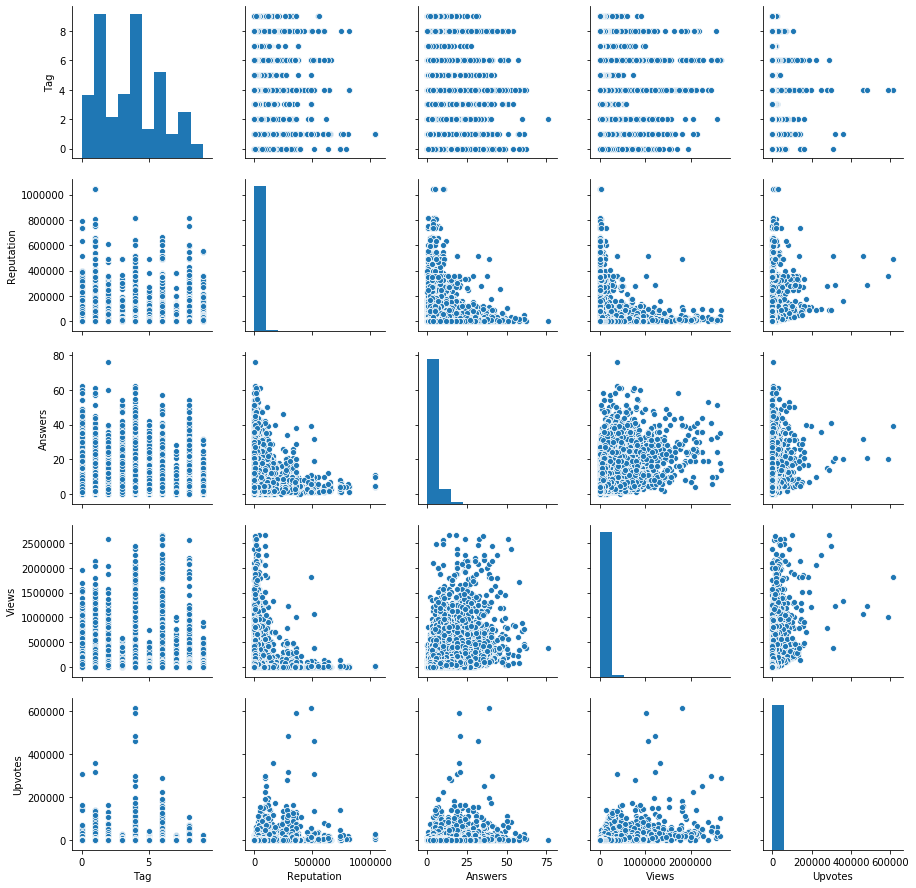

In [8]:
sns.pairplot(train.head(10000))

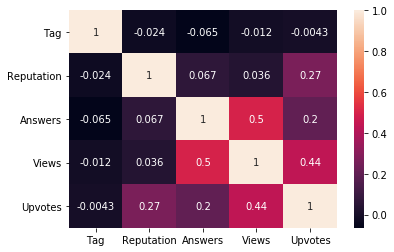

In [7]:
sns.heatmap(train.corr(),annot=True)
# We can see the correlation between the features.

# Check for Multicolinearity


In [8]:
# Getting input features
X = train.drop(['Upvotes'],axis=1)
feat_names = [x for x in X]

In [9]:

for i in range(0,len(feat_names)):
    yy = X.loc[:, X.columns == feat_names[i]]
    xx = X.loc[:, X.columns != feat_names[i]]
    model = sm.OLS(yy, xx)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "R Square value of {} column is {} keeping all other columns as features".format(
            feat_names[i], (round(rsq, 2))
        ))
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            feat_names[i], vif)
    )

R Square value of Tag column is 0.34 keeping all other columns as features
Variance Inflation Factor of Tag column is 1.52 

R Square value of Reputation column is 0.07 keeping all other columns as features
Variance Inflation Factor of Reputation column is 1.07 

R Square value of Answers column is 0.53 keeping all other columns as features
Variance Inflation Factor of Answers column is 2.11 

R Square value of Views column is 0.33 keeping all other columns as features
Variance Inflation Factor of Views column is 1.49 



# Model Building

In [11]:
from sklearn.preprocessing import Binarizer
#Creating a threshold 
bn = Binarizer(threshold=7)
#above 7 is considered as 1 and below 7 we are considering as 0
bn_trans = bn.transform([train['Answers']])[0]
train['bn_trans'] = bn_trans

In [12]:
feature_names = [x for x in train.columns if x not in ['Upvotes']]

x_train, x_test, y_train, y_test = train_test_split(train[feature_names], target,test_size = 0.25,random_state =101)
x_train = Sc.fit_transform(x_train)
x_test = Sc.transform(x_test)

In [13]:
poly_reg = PolynomialFeatures(degree = 5,interaction_only=False, include_bias=True)
X_poly = poly_reg.fit_transform(x_train)
poly_reg.fit(x_train, y_train)
lin_reg = linear_model.LassoLars(alpha=0.021,max_iter=151)
lin_reg.fit(X_poly, y_train)

LassoLars(alpha=0.021, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=151, normalize=True,
          positive=False, precompute='auto', verbose=False)

In [14]:
# predicitng 
preds = lin_reg.predict(poly_reg.fit_transform(x_test))

print(r2_score(y_test, preds))

0.8737819312596978


In [15]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, preds))

MAE: 109.29468942183017


# Applying model for testset

In [16]:
test = pd.read_csv('testupvotes.csv')
ids = test['ID']
test.drop(['ID','Username'], axis=1,inplace =True)
test['Tag'] = Encode.fit_transform(test['Tag'])

In [17]:
bn = Binarizer(threshold=7)
bn_trans = bn.transform([test['Answers']])[0]
test['bn_trans'] = bn_trans

In [18]:
test = Sc.fit_transform(test)
pred_test = lin_reg.predict(poly_reg.fit_transform(test))
pred_test=abs(pred_test)
pred_test=pred_test.astype(int)

In [19]:
Final_submission = pd.DataFrame({'ID': ids,
                           'Upvotes':pred_test
                           })

In [20]:
Final_submission.head()

,ID,Upvotes
0,366953,209
1,71864,98
2,141692,45
3,316833,29
4,440445,277


In [22]:
Final_submission.to_csv("Final_Sub.csv",index=False)